<a href="https://colab.research.google.com/github/donalrinho/Bc2JpsiMuNu/blob/main/Bc2JpsiMuNu_RapidSim_LHCb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse $B_c^+ \to J/\psi \mu^+ \nu_\mu$ RapidSim MC which was generated inside LHCb detector acceptance

In this notebook, we study RapidSim MC which was generated with all particles falling inside the LHCb detector coverage. Instead of looking only at the MC-truth angles, we will also look at the `reconstructed` values - these represent what we would be able to measure in real-life LHCb data. Quite a few features of this notebook are similar to those in [Bc2JpsiMuNu_RapidSim.ipynb](https://github.com/donalrinho/Bc2JpsiMuNu/blob/main/Bc2JpsiMuNu_RapidSim.ipynb), where we looked at a generator-level sample of decays from RapidSim to study MC-truth variables.

In [7]:
#Install uproot for ROOT file loading
!pip install uproot
#We use the vector package to make 4-vectors and manipulate them to calculate the decay angles
!pip install vector

     |████████████████████████████████| 155 kB 9.3 MB/s 


In [8]:
#Import some useful packages
import uproot
import vector
import numpy as np
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Path to RapidSim Bc -> J/psi mu nu file, with events generated inside the LHCb detector
drive_dir = "/content/drive/MyDrive/Bc2JpsiMuNu_ROOT_files"
file_path = f"{drive_dir}/Bc2JpsiMuNu_RapidSim_LHCb"
print(f"Loading ROOT file {file_path}.root")
tree_name = "DecayTree"
events = uproot.open(f"{file_path}.root:{tree_name}")
events

Loading ROOT file /content/drive/MyDrive/Bc2JpsiMuNu_ROOT_files/Bc2JpsiMuNu_RapidSim_LHCb.root


<TTree 'DecayTree' (136 branches) at 0x7f4e2dbd9810>

In [5]:
#Make pandas DataFrame
df = events.arrays(library="pd")

In [6]:
#Check how many events we have in our DataFrame (same as the number of events in the ROOT TTree)
len(df)

912284

Here we have close to 1 million events in our DataFrame. We actually generated 3 million in RapidSim, but only those events falling inside the LHCb detector acceptance are stored in the ROOT file.


## Calculating decay angles and $q^2$

In this notebook, we are going to calculate the true decay angles and $q^2$ like we did in an earlier notebook. But in addition, we also want to calculate these quantities using the information we would actually have available to us in a real data analysis. Because of the missing neutrino, we don't reconstruct the full 4-momentum of our $B_c^+$ particle, and we have to operate with estimates for this quantity.

Let's not worry about the reconstructed angles and $q^2$ for now. But we can still rewrite our angle and $q^2$ calculator functions a little, to anticipate that we want to be able to calculate either true or reconstructed quantities.

In [10]:
def calc_theta_Jpsi(df, var_type):
  """
  Calculate the decay angle theta_Jpsi.

    Parameters:
      df -- input DataFrame (must containin the TRUE PX, PY, PZ, E values for each particle)
      var_type -- whether to calculate true or reconstructed value of the angle
    
    Returns:
      theta_Jpsi -- decay angle values as a numpy array, which can be added to user DataFrame as a new column
  """
  
  if(var_type=="true"):
    var_suff = "_TRUE"
  else:
    var_suff = "_RECO"

  #Muon from the J/psi with the same charge as the Bc
  Jpsi_Mu_vars = {"px": f"Jpsi_Mu0_PX{var_suff}",
                  "py": f"Jpsi_Mu0_PY{var_suff}",
                  "pz": f"Jpsi_Mu0_PZ{var_suff}",
                  "e": f"Jpsi_Mu0_E{var_suff}"}
  
  #J/psi
  Jpsi_vars = {"px": f"Jpsi_PX{var_suff}",
               "py": f"Jpsi_PY{var_suff}",
               "pz": f"Jpsi_PZ{var_suff}",
               "e": f"Jpsi_E{var_suff}"}
  
  #Bc
  Bc_vars = {"px": f"Bc_PX{var_suff}",
             "py": f"Bc_PY{var_suff}",
             "pz": f"Bc_PZ{var_suff}",
             "e": f"Bc_E{var_suff}"}
  
  #4-vectors
  v_Jpsi_Mu = vector.obj(x=df[Jpsi_Mu_vars["px"]],
                         y=df[Jpsi_Mu_vars["py"]],
                         z=df[Jpsi_Mu_vars["pz"]],
                         t=df[Jpsi_Mu_vars["e"]])
  
  v_Jpsi = vector.obj(x=df[Jpsi_vars["px"]],
                      y=df[Jpsi_vars["py"]],
                      z=df[Jpsi_vars["pz"]],
                      t=df[Jpsi_vars["e"]])
  
  v_Bc = vector.obj(x=df[Bc_vars["px"]],
                    y=df[Bc_vars["py"]],
                    z=df[Bc_vars["pz"]],
                    t=df[Bc_vars["e"]])
  
  #Boost to Bc rest frame
  Bc_boost_vec = -(v_Bc.to_beta3())
  v_Jpsi_Mu = v_Jpsi_Mu.boost_beta3(Bc_boost_vec)
  v_Jpsi = v_Jpsi.boost_beta3(Bc_boost_vec)
  v_Bc = v_Bc.boost_beta3(Bc_boost_vec)

  #Boost to J/psi rest frame
  Jpsi_boost_vec = -(v_Jpsi.to_beta3())
  v_Jpsi_Mu = v_Jpsi_Mu.boost_beta3(Jpsi_boost_vec)
  v_Bc = v_Bc.boost_beta3(Jpsi_boost_vec)
  
  #3-vectors
  v3_Jpsi_Mu = v_Jpsi_Mu.to_beta3()
  v3_Bc = v_Bc.to_beta3()
  #Unit vectors
  v3_Jpsi_Mu = v3_Jpsi_Mu / v3_Jpsi_Mu.mag
  v3_Bc = v3_Bc / v3_Bc.mag

  #Angle
  theta_Jpsi = v3_Jpsi_Mu.deltaangle(-v3_Bc)

  return theta_Jpsi

In [11]:
#Calculate the true theta_Jpsi
df["theta_Jpsi_true"] = calc_theta_Jpsi(df, "true")
df["costheta_Jpsi_true"] = np.cos(df["theta_Jpsi_true"])

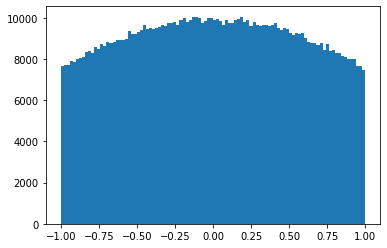

In [12]:
plt.hist(df["costheta_Jpsi_true"],bins=100)
plt.show();

In [13]:
def calc_theta_W(df, var_type):
  """
  Calculate the decay angle theta_W.

    Parameters:
      df -- input DataFrame (must containin the TRUE PX, PY, PZ, E values for each particle)
      var_type -- whether to calculate true or reconstructed value of the angle
    
    Returns:
      theta_W -- decay angle values as a numpy array, which can be added to user DataFrame as a new column
  """

  if(var_type=="true"):
    var_suff = "_TRUE"
  else:
    var_suff = "_RECO"
  
  #Muon from the Bc decay
  Mu_vars = {"px": f"Mu_PX{var_suff}",
             "py": f"Mu_PY{var_suff}",
             "pz": f"Mu_PZ{var_suff}",
             "e": f"Mu_E{var_suff}"}
  
  #Muon from the J/psi with the same charge as the Bc
  Jpsi_Mu_vars = {"px": f"Jpsi_Mu0_PX{var_suff}",
                  "py": f"Jpsi_Mu0_PY{var_suff}",
                  "pz": f"Jpsi_Mu0_PZ{var_suff}",
                  "e": f"Jpsi_Mu0_E{var_suff}"}
  
  #J/psi
  Jpsi_vars = {"px": f"Jpsi_PX{var_suff}",
               "py": f"Jpsi_PY{var_suff}",
               "pz": f"Jpsi_PZ{var_suff}",
               "e": f"Jpsi_E{var_suff}"}
  
  #Bc
  Bc_vars = {"px": f"Bc_PX{var_suff}",
             "py": f"Bc_PY{var_suff}",
             "pz": f"Bc_PZ{var_suff}",
             "e": f"Bc_E{var_suff}"}
  
  #4-vectors
  v_Mu = vector.obj(x=df[Mu_vars["px"]],
                    y=df[Mu_vars["py"]],
                    z=df[Mu_vars["pz"]],
                    t=df[Mu_vars["e"]])
  
  v_Jpsi = vector.obj(x=df[Jpsi_vars["px"]],
                      y=df[Jpsi_vars["py"]],
                      z=df[Jpsi_vars["pz"]],
                      t=df[Jpsi_vars["e"]])
  
  v_Bc = vector.obj(x=df[Bc_vars["px"]],
                    y=df[Bc_vars["py"]],
                    z=df[Bc_vars["pz"]],
                    t=df[Bc_vars["e"]])
  
  #W 4-vector = v_Bc - v_Jpsi
  v_W = v_Bc - v_Jpsi

  #Boost to Bc rest frame
  Bc_boost_vec = -(v_Bc.to_beta3())
  v_Mu = v_Mu.boost_beta3(Bc_boost_vec)
  v_W = v_W.boost_beta3(Bc_boost_vec)
  v_Bc = v_Bc.boost_beta3(Bc_boost_vec)

  #Boost to W rest frame
  W_boost_vec = -(v_W.to_beta3())
  v_Mu = v_Mu.boost_beta3(W_boost_vec)
  v_Bc = v_Bc.boost_beta3(W_boost_vec)
  
  #3-vectors
  v3_Mu = v_Mu.to_beta3()
  v3_Bc = v_Bc.to_beta3()
  #Unit vectors
  v3_Mu = v3_Mu / v3_Mu.mag
  v3_Bc = v3_Bc / v3_Bc.mag

  #Angle
  theta_W = v3_Mu.deltaangle(-v3_Bc)

  return theta_W

In [14]:
#Calculate the true theta_W
df["theta_W_true"] = calc_theta_W(df, "true")
df["costheta_W_true"] = np.cos(df["theta_W_true"])

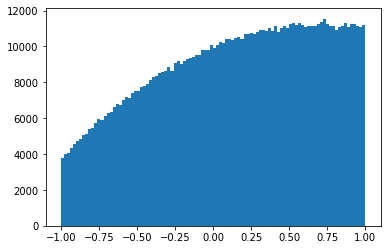

In [15]:
plt.hist(df["costheta_W_true"],bins=100)
plt.show();

In [16]:
def calc_chi(df, var_type):
  """
  Calculate the decay angle chi.

    Parameters:
      df -- input DataFrame (must containin the TRUE PX, PY, PZ, E values for each particle)
      var_type -- whether to calculate true or reconstructed value of the angle
    
    Returns:
      chi -- decay angle values as a numpy array, which can be added to user DataFrame as a new column
  """

  if(var_type=="true"):
    var_suff = "_TRUE"
  else:
    var_suff = "_RECO"
  
  #Muon from the Bc decay
  Mu_vars = {"px": f"Mu_PX{var_suff}",
             "py": f"Mu_PY{var_suff}",
             "pz": f"Mu_PZ{var_suff}",
             "e": f"Mu_E{var_suff}"}
  
  #Muon from the J/psi with the same charge as the Bc
  Jpsi_Mu_vars = {"px": f"Jpsi_Mu0_PX{var_suff}",
                  "py": f"Jpsi_Mu0_PY{var_suff}",
                  "pz": f"Jpsi_Mu0_PZ{var_suff}",
                  "e": f"Jpsi_Mu0_E{var_suff}"}
  
  #J/psi
  Jpsi_vars = {"px": f"Jpsi_PX{var_suff}",
               "py": f"Jpsi_PY{var_suff}",
               "pz": f"Jpsi_PZ{var_suff}",
               "e": f"Jpsi_E{var_suff}"}
  
  #Bc
  Bc_vars = {"px": f"Bc_PX{var_suff}",
             "py": f"Bc_PY{var_suff}",
             "pz": f"Bc_PZ{var_suff}",
             "e": f"Bc_E{var_suff}"}
  
  #4-vectors
  v_Mu = vector.obj(x=df[Mu_vars["px"]],
                    y=df[Mu_vars["py"]],
                    z=df[Mu_vars["pz"]],
                    t=df[Mu_vars["e"]])
  
  v_Jpsi_Mu = vector.obj(x=df[Jpsi_Mu_vars["px"]],
                         y=df[Jpsi_Mu_vars["py"]],
                         z=df[Jpsi_Mu_vars["pz"]],
                         t=df[Jpsi_Mu_vars["e"]])
  
  v_Jpsi = vector.obj(x=df[Jpsi_vars["px"]],
                      y=df[Jpsi_vars["py"]],
                      z=df[Jpsi_vars["pz"]],
                      t=df[Jpsi_vars["e"]])
  
  v_Bc = vector.obj(x=df[Bc_vars["px"]],
                    y=df[Bc_vars["py"]],
                    z=df[Bc_vars["pz"]],
                    t=df[Bc_vars["e"]])
  
  #W 4-vector = v_Bc - v_Jpsi
  v_W = v_Bc - v_Jpsi
  
  #Boost to Bc rest frame
  Bc_boost_vec = -(v_Bc.to_beta3())
  v_Mu = v_Mu.boost_beta3(Bc_boost_vec)
  v_Jpsi_Mu = v_Jpsi_Mu.boost_beta3(Bc_boost_vec)
  v_Jpsi = v_Jpsi.boost_beta3(Bc_boost_vec)
  v_W = v_W.boost_beta3(Bc_boost_vec)
  v_Bc = v_Bc.boost_beta3(Bc_boost_vec)

  v3_Jpsi = v_Jpsi.to_beta3()
  v3_Jpsi = v3_Jpsi / v3_Jpsi.mag

  v3_Jpsi_Mu = v_Jpsi_Mu.to_beta3()
  v3_Jpsi_Mu = v3_Jpsi_Mu / v3_Jpsi_Mu.mag

  v3_Jpsi_Jpsi_Mu = v3_Jpsi.cross(v3_Jpsi_Mu)

  v3_W = v_W.to_beta3()
  v3_W = v3_W / v3_W.mag

  v3_Mu = v_Mu.to_beta3()
  v3_Mu = v3_Mu / v3_Mu.mag

  v3_W_Mu = v3_W.cross(v3_Mu)

  v3_x = v3_Jpsi_Jpsi_Mu / v3_Jpsi_Jpsi_Mu.mag
  v3_z = v3_Jpsi
  v3_y = v3_z.cross(v3_x)
  v3_y = v3_y / v3_y.mag

  C = v3_W_Mu.dot(v3_x)
  S = v3_W_Mu.dot(v3_y)

  chi = np.arctan2(C,S)

  return chi

In [17]:
#Calculate the true chi
df["chi_true"] = calc_chi(df, "true")

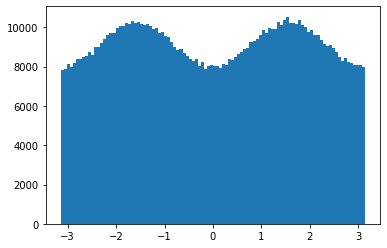

In [18]:
plt.hist(df["chi_true"],bins=100)
plt.show();

In [19]:
def calc_q2(df, var_type):
  """
  Calculate the decay angle chi.

    Parameters:
      df -- input DataFrame (must containin the TRUE PX, PY, PZ, E values for each particle)
      var_type -- whether to calculate true or reconstructed value of the q2
    
    Returns:
      q2 -- momentum transfer as a numpy array, which can be added to user DataFrame as a new column
  """

  if(var_type=="true"):
    var_suff = "_TRUE"
  else:
    var_suff = "_RECO"

  #J/psi
  Jpsi_vars = {"px": f"Jpsi_PX{var_suff}",
               "py": f"Jpsi_PY{var_suff}",
               "pz": f"Jpsi_PZ{var_suff}",
               "e": f"Jpsi_E{var_suff}"}
  
  #Bc
  Bc_vars = {"px": f"Bc_PX{var_suff}",
             "py": f"Bc_PY{var_suff}",
             "pz": f"Bc_PZ{var_suff}",
             "e": f"Bc_E{var_suff}"}

  v_Jpsi = vector.array({
      "px": df[Jpsi_vars["px"]],
      "py": df[Jpsi_vars["py"]],
      "pz": df[Jpsi_vars["pz"]],
      "E": df[Jpsi_vars["e"]]})

  v_Bc = vector.array({
      "px": df[Bc_vars["px"]],
      "py": df[Bc_vars["py"]],
      "pz": df[Bc_vars["pz"]],
      "E": df[Bc_vars["e"]]})

  v_q = v_Bc - v_Jpsi
  q2 = v_q.mass2
  
  return q2

In [20]:
#Add true q2 to our DataFrame
df["q2_true"] = calc_q2(df, "true")

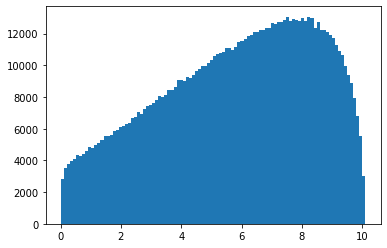

In [21]:
plt.hist(df["q2_true"],bins=100)
plt.show();

So far we have just recalculated the true angles and $q^2$ like in our first notebook. But we tell our functions, based on passing `true` as an argument, to use the variables with `_TRUE` in their name to do the calculations. 

To calculate the reconstructed quantities, we need to point our functions at reconstructed values of the particle momenta. In our ROOT, file, these variables have names for a particle `X`:
 - `X_PX`
 - `X_PY`
 - `X_PZ`
 - `X_E`

Let's rename them to have `_RECO` in their name, to make the distinction between `_TRUE` and `_RECO` clearer.
 

In [22]:
#Rename the reconstructed momenta to have _RECO in their name
for particle in ["Bc","Jpsi","Jpsi_Mu0","Jpsi_Mu1","Mu"]:
  for var in ["PX","PY","PZ","E"]:
    #Rename the branch to have _RECO in the name
    df[f"{particle}_{var}_RECO"] = df[f"{particle}_{var}"]
    #Drop the original column name
    df = df.drop(columns=[f"{particle}_{var}"])

In [23]:
#Check we have the right names
all_vars = df.columns
for x in all_vars:
  if("_RECO" in x):
    print(x)

Bc_PX_RECO
Bc_PY_RECO
Bc_PZ_RECO
Bc_E_RECO
Jpsi_PX_RECO
Jpsi_PY_RECO
Jpsi_PZ_RECO
Jpsi_E_RECO
Jpsi_Mu0_PX_RECO
Jpsi_Mu0_PY_RECO
Jpsi_Mu0_PZ_RECO
Jpsi_Mu0_E_RECO
Jpsi_Mu1_PX_RECO
Jpsi_Mu1_PY_RECO
Jpsi_Mu1_PZ_RECO
Jpsi_Mu1_E_RECO
Mu_PX_RECO
Mu_PY_RECO
Mu_PZ_RECO
Mu_E_RECO


Before we move on to calculating reconstructed angles and $q^2$, we should note that the `Bc` kinematic variables here are quite far in value from the true `Bc` kinematics. This is because these variables do not include the missing neutrino, and so highly underestimate the true 4-momentum of the $B_c^+$. We want to try and improve our estimates for the reconstructed $B_c^+$ momentum, so that we can use those values in our angle and $q^2$ calculations. This will be the subject of our next notebook. 

For now, lets write our latest DataFrame to a new ROOT file.

In [24]:
#Make a new file in our Google Drive, with the same name as our input file but with _Vars added to the end
out_file_path = f"{file_path}_Vars"
outfile = uproot.recreate(f"{out_file_path}.root")

In [25]:
#Add our DataFrame to the file as a TTree with the same name as our input file TTree name
#This might take a little while to run as our DataFrame is quite big
outfile[tree_name] = df

In [26]:
#Close the file to finalise things
outfile.close()